# Notes


# Imports

In [17]:
import numpy as np
import h5py
import time
import pandas as pd
import glob
import matplotlib.pyplot as plt
%load_ext autoreload
import os
%autoreload 2
import sys
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Layout, AppLayout
from matplotlib.gridspec import GridSpec
from ipywidgets import Video, Image, VBox, Text
import ipywidgets as widgets
from sidecar import Sidecar


# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')

from coordinate_transformations import CoordTransformer_14D_PP
from correlation_functions import cross_correlation, angular_cross_correlation

from coordinate_transformations import compute_14D_rep_from_trajectories
from coordinate_transformations import project_14D_rep_onto_modes

# # adding the infomap libs
# from infomap_utils import make_dictionary_of_state_numberings, find_binIdxs_for_timeseries
# from infomap_utils import build_transition_matrix, apply_infomap_clustering_to_transition_matrix
# from infomap_utils import make_binTuple_to_clusterIdx_dict
# from post_processing import contiguous_regions
# from post_processing import process_1D_timeseries



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the main data

In [2]:
#main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'
main_load_folder = '/media/liam/guest_drive/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]


# Compute the 14D timeseries data

In [3]:
pca_savepath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'PCA_data/main.h5')
pca_savepath

'/media/liam/guest_drive/fighting_data/PCA_data/main.h5'

In [4]:
# ---- create a master trajectory to use -----#
#
# We could use all exps, but this is slow, and the result doesnt change.
exp_idxs_to_use = np.unique(fight_bout_info_noDurThresh[:,0])[:]
exp_idxs_to_use

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 17, 18, 19,
       20])

In [5]:
combined_trajectories = []

for expIdx in exp_idxs_to_use:
    
    smooth_traj = np.copy(smooth_trajectories[expIdx])
    
    # make sure winner is first
    winnerIdx = winner_idxs[expIdx]
    if winnerIdx != 0:
        smooth_traj = smooth_traj[:, ::-1]
    combined_trajectories.append(smooth_traj)
    
combined_trajectories = np.concatenate(combined_trajectories)

numFrames_combined, numFish, numBodyPoints, _ = combined_trajectories.shape


# finally we set winnerIdx=0, since we enforced this
winnerIdx=0

## save

In [7]:
# ------ compute and save the PCA ---- #
t0 = time.perf_counter()

# Compute and save
coord_handler = CoordTransformer_14D_PP(combined_trajectories, winnerIdx)
with h5py.File(pca_savepath, 'w') as hf:
    hf.create_dataset('trajectories', data=coord_handler.trajectories)
    hf.create_dataset('rep_14D_tseries', data=coord_handler.rep_14D_tseries)
    hf.create_dataset('mean_14D_rep', data=coord_handler.mean_rep)
    hf.create_dataset('covmat', data=coord_handler.covmat)
    hf.create_dataset('eigvals', data=coord_handler.eigvals)
    hf.create_dataset('eigvecs', data=coord_handler.eigvecs)
    hf.create_dataset('pca_tseries', data=coord_handler.pca_tseries)
    hf.create_dataset('cum_var_explained', data=coord_handler.cum_var_explained)
    hf.create_dataset('winnerIdx', data=coord_handler.winnerIdx)


tE = time.perf_counter()
print(tE-t0, ' s')

1802.342042954173  s


## load

In [109]:
t0 = time.perf_counter()

# Load
with h5py.File(pca_savepath, 'r') as hf:
    
    trajectories = hf['trajectories'][:]
    rep_14D_tseries = hf['rep_14D_tseries'][:]
    mean_14D_rep = hf['mean_14D_rep'][:]
    covmat = hf['covmat'][:]
    eigvals = hf['eigvals'][:]
    eigvecs = hf['eigvecs'][:]
    pca_tseries = hf['pca_tseries'][:]
    cum_var_explained = hf['cum_var_explained'][:]
    winnerIdx = hf['winnerIdx'][()]

coord_handler = CoordTransformer_14D_PP(trajectories, winnerIdx,
                             rep_14D_tseries=rep_14D_tseries)

tE = time.perf_counter()
print(tE-t0, ' s')

43.0832434091717  s


# Look at the eigenvectors and the mean configuration of the 14D timeseries

In [58]:
# The eigenvectors
eigvec_df = pd.DataFrame(data=np.round(coord_handler.eigvecs,3),
                         index=coord_handler.data_order,
                         columns=['mode {0}'.format(i+1) for i in range(14)])

eigvec_df

,mode 1,mode 2,mode 3,mode 4,mode 5,mode 6,mode 7,mode 8,mode 9,mode 10,mode 11,mode 12,mode 13,mode 14
winner_pec_x,-0.426,-0.128,-0.001,0.000,-0.014,-0.169,0.004,-0.001,-0.003,-0.006,-0.003,-0.392,0.786,0.034
winner_pec_z,-0.130,0.428,0.004,-0.002,-0.004,0.001,-0.023,0.175,-0.005,-0.021,-0.003,-0.175,-0.051,-0.857
winner_head_x,-0.433,-0.131,0.281,0.003,-0.033,-0.430,0.021,-0.003,-0.098,-0.638,-0.102,0.186,-0.261,-0.006
winner_head_y,-0.001,0.003,-0.002,0.211,0.304,-0.022,-0.005,0.001,-0.605,0.202,-0.675,-0.002,-0.004,0.002
winner_head_z,-0.130,0.424,0.014,-0.003,-0.008,-0.008,-0.313,0.422,-0.005,-0.037,-0.001,-0.504,-0.272,0.445
winner_tail_x,-0.413,-0.120,-0.707,-0.005,0.037,0.477,-0.031,-0.000,-0.038,-0.255,-0.040,0.073,-0.106,-0.001
winner_tail_y,0.003,-0.006,0.001,-0.537,-0.755,0.057,0.009,-0.002,-0.241,0.079,-0.271,0.000,-0.002,0.001
winner_tail_z,-0.129,0.439,-0.017,0.001,0.007,0.019,0.711,-0.449,-0.002,-0.014,-0.002,-0.202,-0.107,0.176
loser_head_x,0.418,0.119,0.245,0.003,0.036,0.474,0.007,0.017,-0.101,-0.639,-0.101,-0.094,0.295,0.019
loser_head_y,-0.002,-0.001,0.003,-0.309,0.217,-0.016,0.001,0.001,-0.687,0.009,0.620,0.005,0.001,0.001


In [59]:
# the mean configuration

mean_rep_df = pd.DataFrame(data=np.round(coord_handler.mean_rep,3),
                           index=coord_handler.data_order,
                           columns=['mean representation'])

mean_rep_df

,mean representation
winner_pec_x,-3.815
winner_pec_z,-0.545
winner_head_x,-3.707
winner_head_y,0.001
winner_head_z,-0.542
winner_tail_x,-3.997
winner_tail_y,-0.000
winner_tail_z,-0.544
loser_head_x,3.839
loser_head_y,-0.026


# v1

In [63]:
eigvecs.shape

(14, 14)

In [65]:
eigvec_df

,mode 1,mode 2,mode 3,mode 4,mode 5,mode 6,mode 7,mode 8,mode 9,mode 10,mode 11,mode 12,mode 13,mode 14
winner_pec_x,-0.426,-0.128,-0.001,0.000,-0.014,-0.169,0.004,-0.001,-0.003,-0.006,-0.003,-0.392,0.786,0.034
winner_pec_z,-0.130,0.428,0.004,-0.002,-0.004,0.001,-0.023,0.175,-0.005,-0.021,-0.003,-0.175,-0.051,-0.857
winner_head_x,-0.433,-0.131,0.281,0.003,-0.033,-0.430,0.021,-0.003,-0.098,-0.638,-0.102,0.186,-0.261,-0.006
winner_head_y,-0.001,0.003,-0.002,0.211,0.304,-0.022,-0.005,0.001,-0.605,0.202,-0.675,-0.002,-0.004,0.002
winner_head_z,-0.130,0.424,0.014,-0.003,-0.008,-0.008,-0.313,0.422,-0.005,-0.037,-0.001,-0.504,-0.272,0.445
winner_tail_x,-0.413,-0.120,-0.707,-0.005,0.037,0.477,-0.031,-0.000,-0.038,-0.255,-0.040,0.073,-0.106,-0.001
winner_tail_y,0.003,-0.006,0.001,-0.537,-0.755,0.057,0.009,-0.002,-0.241,0.079,-0.271,0.000,-0.002,0.001
winner_tail_z,-0.129,0.439,-0.017,0.001,0.007,0.019,0.711,-0.449,-0.002,-0.014,-0.002,-0.202,-0.107,0.176
loser_head_x,0.418,0.119,0.245,0.003,0.036,0.474,0.007,0.017,-0.101,-0.639,-0.101,-0.094,0.295,0.019
loser_head_y,-0.002,-0.001,0.003,-0.309,0.217,-0.016,0.001,0.001,-0.687,0.009,0.620,0.005,0.001,0.001


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
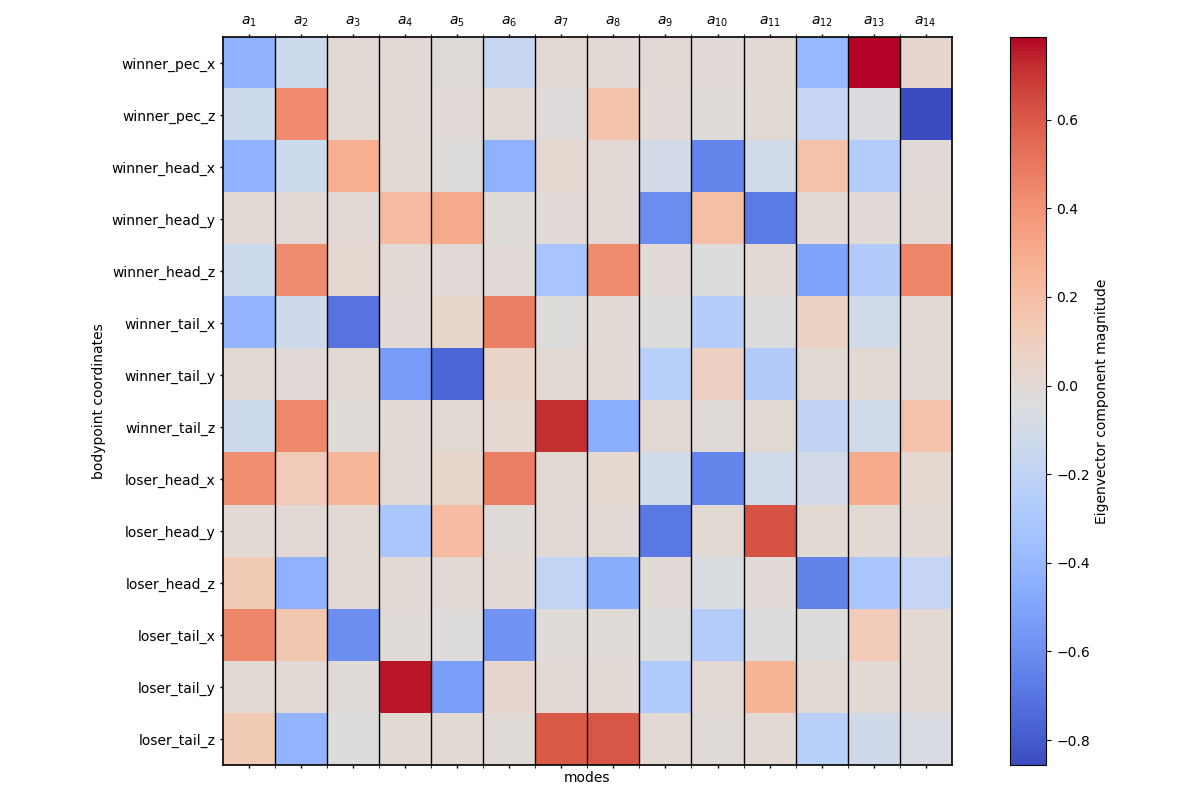

In [172]:
# Create the heatmap using subplots

column_sep = 100  # Adjust this value to set the separation between columns

fig, axs = plt.subplots(figsize=(12, 8))
ax = axs

cax = ax.matshow(eigvecs, cmap='coolwarm', interpolation="none")
fig.colorbar(cax, label='Eigenvector component magnitude')

ax.set_title('')
ax.set_xlabel('modes')
ax.set_ylabel('bodypoint coordinates')

ax.set_xticks(np.arange(14))
ax.set_yticks(np.arange(14))

xlabs = [f'a_{{{i}}}' for i in range(1,15)]
ax.set_xticklabels([r'${0}$'.format(xlabs[i]) for i in range(len(xlabs))])
ax.set_yticklabels(coord_handler.data_order)

# Turn on the grid
ax.set_xticks((ax.get_xticks()+0.5)[:-1], minor=True)
ax.grid(True, which='minor', axis='x', linestyle='-', color='k', linewidth=1)


# # The spines and ticks
for axis in ['left', 'right', 'top', 'bottom']:
     ax.spines[axis].set_linewidth(1.2)
ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)



# save and finish
fig.tight_layout()
#fig.savefig('/home/liam/temp/image_transfer/rebuttle_fig1_panel.png', dpi=900, transparent=True)

#fig.tight_layout()
fig.show()


In [72]:
pcIdx = 0
eigvecs[:,pcIdx]

array([-0.42623395, -0.12965535, -0.43310068, -0.00139461, -0.13008591,
       -0.41254818,  0.00343746, -0.12898212,  0.41809954, -0.00210891,
        0.13039283,  0.4493993 ,  0.00520945,  0.12793975])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
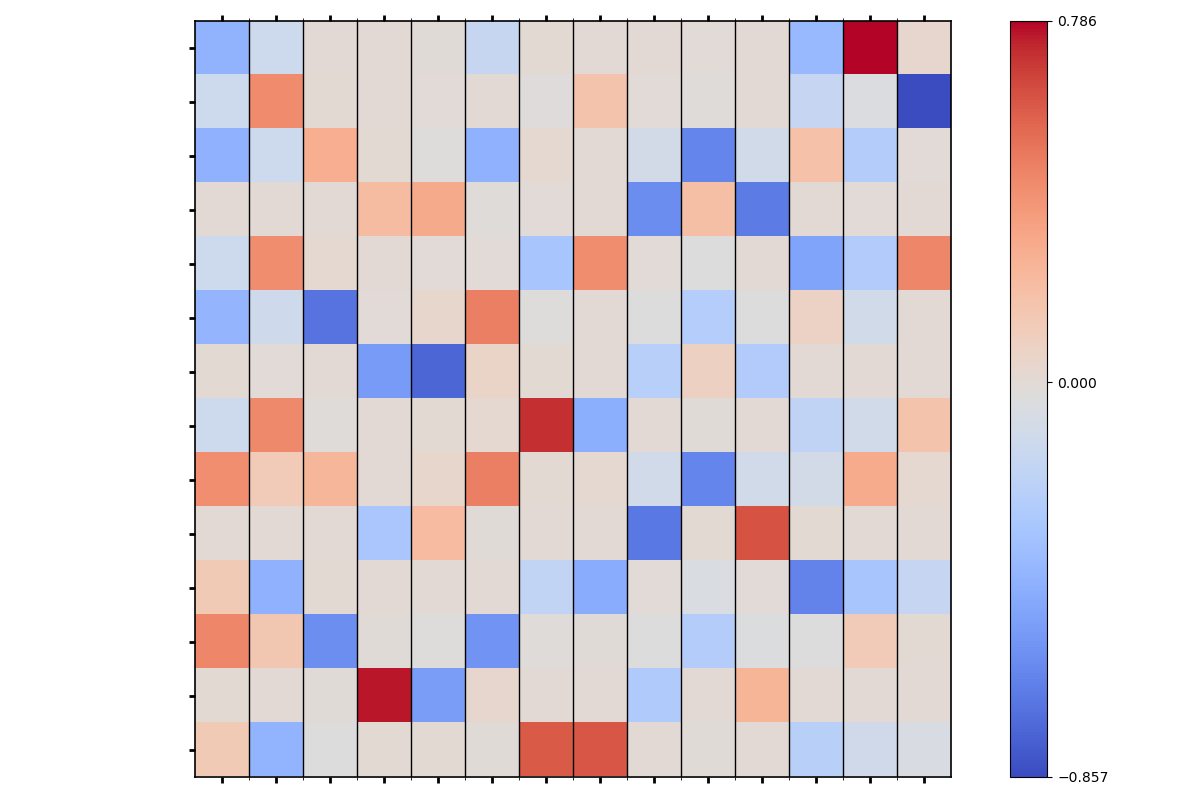

In [203]:
# Create the heatmap using subplots

column_sep = 100  # Adjust this value to set the separation between columns

fig, axs = plt.subplots(figsize=(12, 8))
ax = axs

cax = ax.matshow(eigvecs, cmap='coolwarm', interpolation="none")
cbar = fig.colorbar(cax, label='')

# adjust the colorbar
vmin, vmax = cax.get_clim()
cbar.set_ticks([vmin, 0, vmax])
#cbar.set_ticklabels(['0.1', '0.3', '0.5', '0.7', '0.9'])

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xticks(np.arange(14))
ax.set_yticks(np.arange(14))

xlabs = [f'a_{{{i}}}' for i in range(1,15)]
ax.set_xticklabels([])
ax.set_yticklabels([])

# Turn on the grid
ax.set_xticks((ax.get_xticks()+0.5)[:-1], minor=True)
ax.grid(True, which='minor', axis='x', linestyle='-', color='k', linewidth=1)

# # The spines and ticks
for axis in ['left', 'right', 'top', 'bottom']:
     ax.spines[axis].set_linewidth(1.2)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)

# save and finish
fig.tight_layout()
#fig.savefig('/home/liam/temp/image_transfer/rebuttle_fig1_panel.png', dpi=900, transparent=True)

#fig.tight_layout()
fig.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
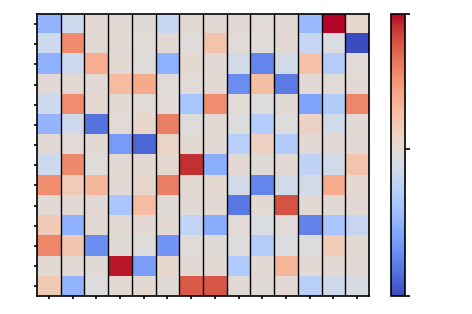

In [221]:
# Create the heatmap using subplots


# Define the size in centimeters (1 inch = 2.54 cm)
width_cm = 12
height_cm = 8
width_inch = width_cm / 2.54
height_inch = height_cm / 2.54


# -----------------

fig, axs = plt.subplots()
fig.set_size_inches(width_inch, height_inch)

ax = axs

cax = ax.matshow(eigvecs, cmap='coolwarm', interpolation="none")
cbar = fig.colorbar(cax, label='')

# adjust the colorbar
vmin, vmax = cax.get_clim()
cbar.set_ticks([vmin, 0, vmax])
cbar.set_ticklabels([])
cbar.outline.set_linewidth(1.2) 
cbar.ax.tick_params(width=1.2) 


ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xticks(np.arange(14))
ax.set_yticks(np.arange(14))

xlabs = [f'a_{{{i}}}' for i in range(1,15)]
ax.set_xticklabels([])
ax.set_yticklabels([])

# Turn on the grid for minor ticks
ax.set_xticks((ax.get_xticks()+0.5)[:-1], minor=True)
ax.grid(True, which='minor', axis='x', linestyle='-', color='k', linewidth=1)

# # The spines and ticks
for axis in ['left', 'right', 'top', 'bottom']:
     ax.spines[axis].set_linewidth(1.2)
ax.xaxis.set_tick_params(width=1.2, length=2)
ax.yaxis.set_tick_params(width=1.2, length=2)

# off off minor ticks
ax.xaxis.set_tick_params(width=1.2, length=0, which='minor')
ax.yaxis.set_tick_params(width=1.2, length=0, which='minor')

# Turn off x-ticks at the top of the plot
ax.xaxis.set_ticks_position('bottom')  # Set x-ticks to bottom
ax.xaxis.set_label_position('bottom')  # Set x-label to bottom

ax.set_aspect(aspect=0.85)

# save and finish
fig.tight_layout()
fig.savefig('/home/liam/temp/image_transfer/SI_pca_eigvecs_im.png', dpi=600, transparent=True)

#fig.tight_layout()
fig.show()

# --------------------------------------

# ---------

# Look at the eigenvectors and the mean configuration of the 14D timeseries

In [ ]:
# First look at the loading of the various PCA modes to see if you have any interpretation
#
# Then look at the mean configuation. For the fish backbone, is this mean configuration,
# which is the mean of the 20 angles across the experiment, close to 0 in all angles? (Straight?)

In [42]:
# The eigenvectors
eigvec_df = pd.DataFrame(data=np.round(coord_handler.eigvecs,3),
                         index=coord_handler.data_order,
                         columns=['mode {0}'.format(i+1) for i in range(14)])

eigvec_df

,mode 1,mode 2,mode 3,mode 4,mode 5,mode 6,mode 7,mode 8,mode 9,mode 10,mode 11,mode 12,mode 13,mode 14
winner_pec_x,-0.426,-0.128,-0.001,0.000,-0.014,-0.169,0.004,-0.001,-0.003,-0.006,-0.003,-0.392,0.786,0.034
winner_pec_z,-0.130,0.428,0.004,-0.002,-0.004,0.001,-0.023,0.175,-0.005,-0.021,-0.003,-0.175,-0.051,-0.857
winner_head_x,-0.433,-0.131,0.281,0.003,-0.033,-0.430,0.021,-0.003,-0.098,-0.638,-0.102,0.186,-0.261,-0.006
winner_head_y,-0.001,0.003,-0.002,0.211,0.304,-0.022,-0.005,0.001,-0.605,0.202,-0.675,-0.002,-0.004,0.002
winner_head_z,-0.130,0.424,0.014,-0.003,-0.008,-0.008,-0.313,0.422,-0.005,-0.037,-0.001,-0.504,-0.272,0.445
winner_tail_x,-0.413,-0.120,-0.707,-0.005,0.037,0.477,-0.031,-0.000,-0.038,-0.255,-0.040,0.073,-0.106,-0.001
winner_tail_y,0.003,-0.006,0.001,-0.537,-0.755,0.057,0.009,-0.002,-0.241,0.079,-0.271,0.000,-0.002,0.001
winner_tail_z,-0.129,0.439,-0.017,0.001,0.007,0.019,0.711,-0.449,-0.002,-0.014,-0.002,-0.202,-0.107,0.176
loser_head_x,0.418,0.119,0.245,0.003,0.036,0.474,0.007,0.017,-0.101,-0.639,-0.101,-0.094,0.295,0.019
loser_head_y,-0.002,-0.001,0.003,-0.309,0.217,-0.016,0.001,0.001,-0.687,0.009,0.620,0.005,0.001,0.001


In [43]:
# the mean configuration

mean_rep_df = pd.DataFrame(data=np.round(coord_handler.mean_rep,3),
                           index=coord_handler.data_order,
                           columns=['mean representation'])

mean_rep_df

,mean representation
winner_pec_x,-3.815
winner_pec_z,-0.545
winner_head_x,-3.707
winner_head_y,0.001
winner_head_z,-0.542
winner_tail_x,-3.997
winner_tail_y,-0.000
winner_tail_z,-0.544
loser_head_x,3.839
loser_head_y,-0.026


# Variance explained

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
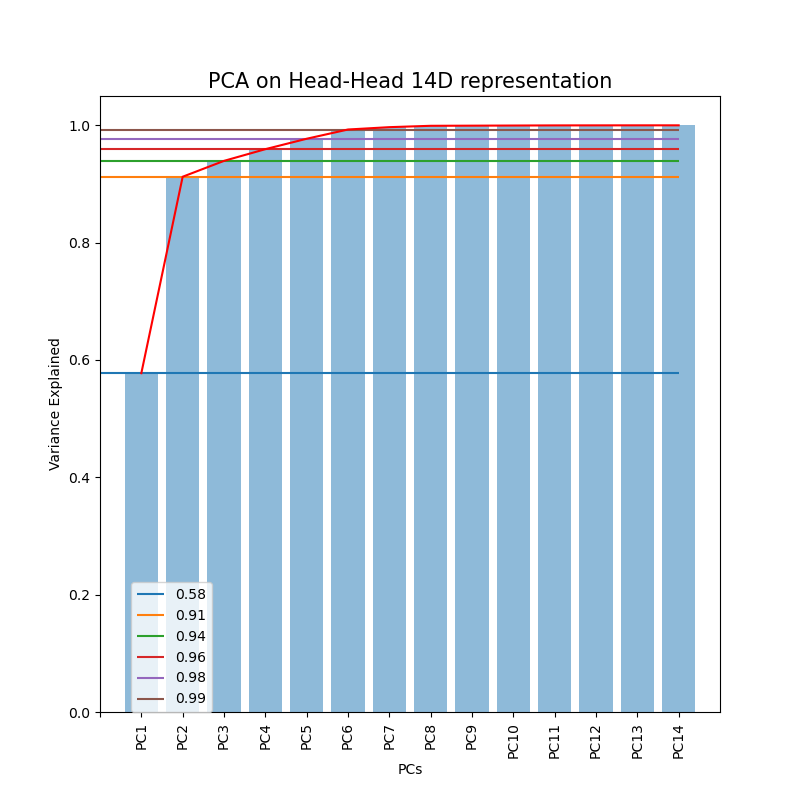

In [44]:
# ---- Variance explained --- #

# get the dimension of the timeseries
dim = coord_handler.covmat.shape[0]

# get the xvalues for plotting (non zero indexed)
x_vals = np.arange(1,dim+1)
x_text_vals = [' ', "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14"]

# make the plot
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(x_vals, coord_handler.cum_var_explained, color='red')
ax.bar(x_vals, coord_handler.cum_var_explained, alpha=0.5)
ax.set_title('PCA on Head-Head 14D representation', fontdict={'fontsize':15})

ax.set_ylabel('Variance Explained')
ax.set_xlabel('PCs')
ax.set_xlim(0,len(x_text_vals))
ax.set_xticks(np.arange(len(x_text_vals)))
ax.set_xticklabels(x_text_vals, rotation='vertical', fontsize=10)


pcIdx = 0
ax.hlines(coord_handler.cum_var_explained[pcIdx], 0, 14, label='{:.2f}'.format(coord_handler.cum_var_explained[pcIdx]), colors='C0')
pcIdx = 1
ax.hlines(coord_handler.cum_var_explained[pcIdx], 0, 14, label='{:.2f}'.format(coord_handler.cum_var_explained[pcIdx]), colors='C1')
pcIdx = 2
ax.hlines(coord_handler.cum_var_explained[pcIdx], 0, 14, label='{:.2f}'.format(coord_handler.cum_var_explained[pcIdx]), colors='C2')
pcIdx = 3
ax.hlines(coord_handler.cum_var_explained[pcIdx], 0, 14, label='{:.2f}'.format(coord_handler.cum_var_explained[pcIdx]), colors='C3')
pcIdx = 4
ax.hlines(coord_handler.cum_var_explained[pcIdx], 0, 14, label='{:.2f}'.format(coord_handler.cum_var_explained[pcIdx]), colors='C4')
pcIdx = 5
ax.hlines(coord_handler.cum_var_explained[pcIdx], 0, 14, label='{:.2f}'.format(coord_handler.cum_var_explained[pcIdx]), colors='C5')
plt.legend(loc=(0.05, 0.))
plt.show()

# Mode weight Distributions

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
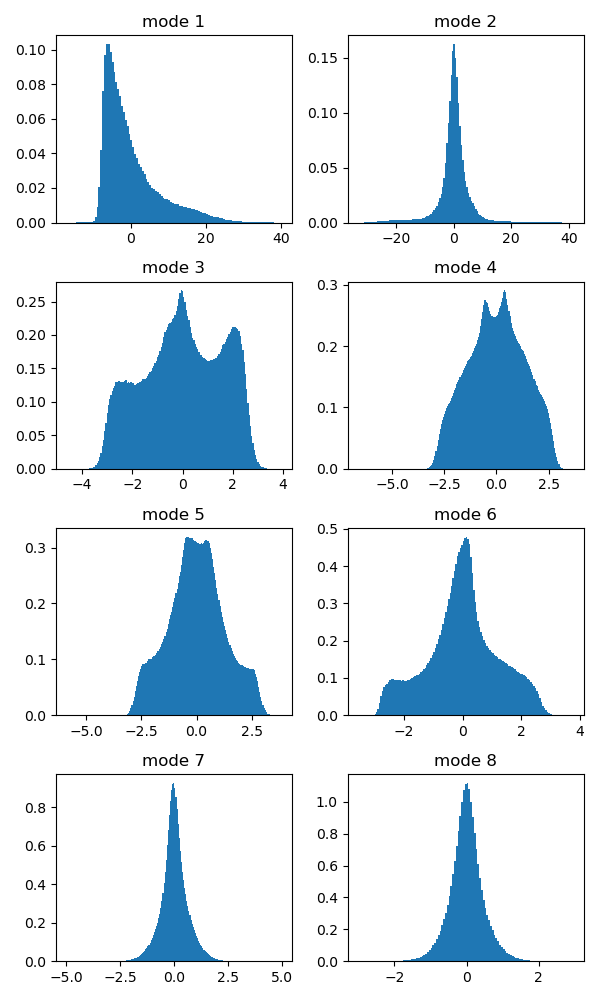

In [45]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(6, 10))

pca_tseries = np.copy(coord_handler.pca_tseries)

pc1 = pca_tseries[:,0][~np.isnan(pca_tseries[:,0])]
pc2 = pca_tseries[:,1][~np.isnan(pca_tseries[:,1])]
pc3 = pca_tseries[:,2][~np.isnan(pca_tseries[:,2])]
pc4 = pca_tseries[:,3][~np.isnan(pca_tseries[:,3])]
pc5 = pca_tseries[:,4][~np.isnan(pca_tseries[:,4])]
pc6 = pca_tseries[:,5][~np.isnan(pca_tseries[:,5])]
pc7 = pca_tseries[:,6][~np.isnan(pca_tseries[:,6])]
pc8 = pca_tseries[:,7][~np.isnan(pca_tseries[:,7])]
pc_data = [pc1, pc2, pc3, pc4, pc5, pc6, pc7, pc8]
    

# pc1
data = pc_data[0]
axs[0, 0].set_title('mode {0}'.format(1))
axs[0, 0].hist(data, bins=np.arange(np.min(data)-0.1, np.max(data)+0.1, 0.5), density=True)

# pc2
data = pc_data[1]
axs[0, 1].set_title('mode {0}'.format(2))
axs[0, 1].hist(data, bins=np.arange(np.min(data)-0.1, np.max(data)+0.1, 0.5), density=True)

# pc3
data = pc_data[2]
axs[1, 0].set_title('mode {0}'.format(3))
axs[1, 0].hist(data, bins=np.arange(np.min(data)-0.1, np.max(data)+0.1, 0.05), density=True)

# pc4
data = pc_data[3]
axs[1, 1].set_title('mode {0}'.format(4))
axs[1, 1].hist(data, bins=np.arange(np.min(data)-0.1, np.max(data)+0.1, 0.05), density=True)

# pc5
data = pc_data[4]
axs[2, 0].set_title('mode {0}'.format(5))
axs[2, 0].hist(data, bins=np.arange(np.min(data)-0.1, np.max(data)+0.1, 0.05), density=True)

# pc6
data = pc_data[5]
axs[2, 1].set_title('mode {0}'.format(6))
axs[2, 1].hist(data, bins=np.arange(np.min(data)-0.1, np.max(data)+0.1, 0.05), density=True)

# pc7
data = pc_data[6]
axs[3, 0].set_title('mode {0}'.format(7))
axs[3, 0].hist(data, bins=np.arange(-5, 5, 0.05), density=True)

# pc8
data = pc_data[7]
axs[3, 1].set_title('mode {0}'.format(8))
axs[3, 1].hist(data, bins=np.arange(-3, 3, 0.05), density=True)


fig.tight_layout()
plt.show()

#  Widgits

## Make the widgets to hold the data

In [46]:
### Prepare the list of widgets ###


# layout parameters
number_layout = widgets.Layout(width='70px')
text_layout = widgets.Layout(width='120px')

# preallocate list structures to hold the numbers
plottable_3D_widget_list = [ [[[] for _ in range(3)] for _ in range(numBodyPoints)] for _ in range(numFish)]
pca_widget_list = [ [] for i in range(14)]
rep_widget_list = [ [] for i in range(14)]

# get the plottable positions for the frame
#plottable_positions = rep14D_to_plotable_positions(mean_14D_rep)
plottable_positions = coord_handler.convert_rep14D_to_plotable_positions(coord_handler.mean_rep)

# grab the plottable values
for fishIdx in range(numFish):
    for bpIdx in range(numBodyPoints):
        for dimIdx in range(3):
             
            # plottable data
            wid_val = np.round(np.copy(plottable_positions[fishIdx, bpIdx, dimIdx]), 2)
            val_widge_3D = widgets.FloatText(value=wid_val,layout=number_layout)
            plottable_3D_widget_list[fishIdx][bpIdx][dimIdx] = val_widge_3D
            
# grab the pca values
mean_rep_modes = coord_handler.convert_rep14D_to_mode_weights(coord_handler.mean_rep)
for pcIdx in range(14):
    wid_val = np.round(np.copy(mean_rep_modes[pcIdx]), 2)
    val_widge_3D = widgets.FloatText(value=wid_val,layout=number_layout)
    pca_widget_list[pcIdx] = val_widge_3D
    
# grab the rep values
for pcIdx in range(14):
    wid_val = np.round(np.copy(coord_handler.mean_rep[pcIdx]), 2)
    val_widge_3D = widgets.FloatText(value=wid_val,layout=number_layout)
    rep_widget_list[pcIdx] = val_widge_3D

In [47]:
### Make widgets to vizualize the plottable positions


# layout parameters
number_layout = widgets.Layout(width='80px')
text_layout = widgets.Layout(width='120px')

# widget lists
f_bp_XYZ_boxes = [None]*numFish
f_3D_wid_titles = [None]*numFish
f_3D_wids = [None]*numFish

for fishIdx in range(numFish):
    f_bp_box_list = []
    for bpIdx in range(numBodyPoints):
        f_bp_XYZ_boxes[fishIdx] = widgets.HBox(plottable_3D_widget_list[fishIdx][bpIdx][:], layout=widgets.Layout(padding=('0px 30px 0 0')))
        f_bp_box_list.append(f_bp_XYZ_boxes[fishIdx])
    f_3D_wid_titles[fishIdx] = widgets.Text('Fish{} FC bps'.format(fishIdx+1), layout=text_layout)
    f_3D_wids[fishIdx] = widgets.VBox([f_3D_wid_titles[fishIdx]]+f_bp_box_list)

# Final widget
plottable_frame_widget = widgets.HBox(f_3D_wids, layout=widgets.Layout(padding=('0px 0px 30px 200px')))

In [48]:
### Make widgets to vizualize the pca_data

# layout parameters
number_layout = widgets.Layout(width='80px')
text_layout = widgets.Layout(width='120px')
wid_title = widgets.Text('mode weights', layout=text_layout)

# get the values of the widget in a hbox
mode_weight_vals_wid = widgets.HBox(pca_widget_list, layout=widgets.Layout(padding=('0px 0px 00px 000px')))

# make the final widget with title
mode_frame_widget = widgets.VBox([wid_title, mode_weight_vals_wid], layout=widgets.Layout(padding=('0px 0px 30px 200px')))


### Make widgets to vizualize the rep_data

# layout parameters
number_layout = widgets.Layout(width='80px')
text_layout = widgets.Layout(width='120px')
wid_title = widgets.Text('14D rep', layout=text_layout)

# get the values of the widget in a hbox
rep_vals_wid = widgets.HBox(rep_widget_list, layout=widgets.Layout(padding=('0px 0px 00px 000px')))

# make the final widget with title
rep_frame_widget = widgets.VBox([wid_title, rep_vals_wid], layout=widgets.Layout(padding=('0px 0px 30px 200px')))

In [49]:
# final widget


data_widget = widgets.VBox([plottable_frame_widget, mode_frame_widget, rep_frame_widget],
                                    layout=widgets.Layout(display="flex-start"))

#data_widget

## Make the 3D plotting widget

In [50]:
#  ----------------- make a 3D plot of the positions ----------------------- #

plt.ioff()


rep_data = np.copy(coord_handler.mean_rep)
pca_data = coord_handler.convert_rep14D_to_mode_weights(rep_data)
frame_positions = coord_handler.convert_rep14D_to_plotable_positions(rep_data)

numFish, numBodyPoints = 2, 3
fish_colors = ['red', 'blue']

# Attaching 3D axis to the figure
fig = plt.figure()
fig.tight_layout()
fig.canvas.header_visible = False
#fig.canvas.layout.min_height = '400px'
fig.canvas.layout.height = '100%'
fig.canvas.layout.width = '100%'
ax = fig.add_subplot(111, projection='3d')  
fig.suptitle('Investigating PCA mode action about mean configuration')
#ax = p3.Axes3D(fig, [0.,0.,1.,1.])

# set the limits
xmin, xmax = -5, 5
ymin, ymax = -5, 5
zmin, zmax = -5, 5

# Setting the axes properties
ax.set_xlim3d([xmin, xmax])
ax.set_xlabel('X')

ax.set_ylim3d([ymin, ymax])
ax.set_ylabel('Y')

ax.set_zlim3d([zmin, zmax])
ax.set_zlabel('Z')

# Initialize scatters (list over fish, list over bps)
symbols = ['o', 's', 'x']
sizes=12

# Main scatters
scatters = []
for fishIdx in range(numFish):
    col = fish_colors[fishIdx]
    fish_scatters = []
    for bpIdx in range(numBodyPoints):
        fish_scatters.append(ax.scatter(frame_positions[fishIdx, bpIdx, 0], 
                                        frame_positions[fishIdx, bpIdx, 1], 
                                        frame_positions[fishIdx, bpIdx, 2], 
                                        c=col, s=sizes, marker=symbols[bpIdx])) 
    scatters.append(fish_scatters)
    
# Main lines
lines = []
for fishIdx in range(numFish):
    col = fish_colors[fishIdx]
    line = ax.plot(frame_positions[fishIdx, :, 0], frame_positions[fishIdx, :, 1], frame_positions[fishIdx, :, 2], c=col)[0]
    lines.append(line)
    
# scatterplot the origin
ax.scatter(0, 0, 0, c='black', s=14)
        
sizes=5

scatter_projections = []
lines_projections = []
for projectionIdx in range(3):
        
    # XZ => Y
    if projectionIdx == 0:
        projectionData = np.copy(frame_positions)
        projectionData[:, :, 1] = ymax
    # XY => Z
    elif projectionIdx == 1:
        projectionData = np.copy(frame_positions)
        projectionData[:, :, 2] = zmin
    # YZ => X
    elif projectionIdx == 2:
        projectionData = np.copy(frame_positions)
        projectionData[:, :, 0] = xmin
    
    proj_scatters = []
    proj_lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        # scatter plots
        fish_scatters = []
        for bpIdx in range(numBodyPoints):
            #print(symbols[bpIdx])
            fish_scatters.append(ax.scatter(projectionData[fishIdx, bpIdx, 0], projectionData[fishIdx, bpIdx, 1], projectionData[fishIdx, bpIdx, 2], 
                                            c=col, s=sizes, marker=symbols[bpIdx], alpha=0.1))
        # lines
        line = ax.plot(projectionData[fishIdx, :, 0], projectionData[fishIdx, :, 1], projectionData[fishIdx, :, 2], c=col, alpha=0.1)[0]
        proj_lines.append(line)
        proj_scatters.append(fish_scatters)

    scatter_projections.append(proj_scatters)
    lines_projections.append(proj_lines)
    
    
    
    
    
# make the widget
layout = widgets.Layout(width='100%')
plot_widget = VBox([fig.canvas], layout=layout)

## Make the Slider widgets

In [55]:
# make the 8 sliders
numModeSliders = 14

mode_sliders = []

for ii in range(numModeSliders):
    
    # get the slider ranges and step
    if ii == 6:
        slider_min = -5
        slider_max = 5
        step=0.01
        init_val = pca_widget_list[ii].value
    elif ii == 7:
        slider_min = -5
        slider_max = 5
        step=0.01
        init_val = pca_widget_list[ii].value
    else:
        slider_min = np.nanmin(pca_tseries[:,ii])
        slider_max = np.nanmax(pca_tseries[:,ii])
        step=0.01
        init_val = pca_widget_list[ii].value
        
    # make the slider
    mode_slider = widgets.FloatSlider(value=init_val, min=slider_min, max=slider_max, step=step, 
                                         continuous_update=True, description='m{0}: {1}'.format(ii+1, np.round(mean_rep_modes[ii],2)), 
                                          layout=Layout(width='100%', height='50px'))
    
    # link the slider to the widget display values
    mode_val_slider_link = widgets.link((mode_slider, 'value'), (pca_widget_list[ii], 'value'))
    
    # keep the mode slider
    mode_sliders.append(mode_slider)
    
    
    
    
# ------- On changes to the mode sliders, update the plottable positions ------ #

def update_plottable_from_mode_sliders(change):
    numCams=3
    numFish=2
    numBodyPoints=3
    
    # get the current values of the mode weights
    pca_data = []
    for ii in range(numModeSliders):
        pca_weight = pca_widget_list[ii].value
        pca_data.append(pca_weight)
    frame_pca_data = np.array(pca_data)
    
    # get the representation data from the pca weights
    #frame_rep_data = modes_to_14D_rep(frame_pca_data, mean_14D_rep, sorted_eig_vecs)
    frame_rep_data = coord_handler.convert_mode_weights_to_14D_rep(frame_pca_data)
    
    # get the plottable positions
    #frame_positions = rep14D_to_plotable_positions(frame_rep_data)
    frame_positions = coord_handler.convert_rep14D_to_plotable_positions(frame_rep_data)
    
    # update the rep data
    for ii in range(14):
        rep_widget_list[ii].value = np.round(frame_rep_data[ii],3)
        
    # update the plottable positions (lab can't be updated)
    for fishIdx in range(numFish):
        for bpIdx in range(numBodyPoints):
            for dimIdx in range(3):
                plottable_3D_widget_list[fishIdx][bpIdx][dimIdx].value = np.round(frame_positions[fishIdx, bpIdx, dimIdx],3)
            
    
for ii in range(numModeSliders):
    mode_sliders[ii].observe(update_plottable_from_mode_sliders, names='value')
    
    
# all sliders
all_sliders = widgets.VBox([widgets.VBox(mode_sliders)])



# ----- Update the plot with mode sliders ----- #


def update_plot_mode_change(change):
    numFish=2
    numBodyPoints=3
    fig.suptitle('Investigating PCA mode action about mean configuration')
    
    #------ Gather the current frame positions from the widget --- #
    frame_positions = []
    for fishIdx in range(numFish):

        fish_position = []
        for bpIdx in range(numBodyPoints):

            bodypoint_pos = []
            for dimIdx in range(3):
                val = plottable_3D_widget_list[fishIdx][bpIdx][dimIdx].value
                bodypoint_pos.append(val)
            bodypoint_pos = np.array(bodypoint_pos)

            fish_position.append(bodypoint_pos)
        fish_position = np.stack(fish_position)

        frame_positions.append(fish_position)
    frame_positions = np.stack(frame_positions)
    #-------------------------------------#
        
        
    #------- Update the real fish ---- #
    # update the scatters
    for fishIdx in range(numFish):
        for bpIdx in range(numBodyPoints):
            ax = scatters[fishIdx][bpIdx]
            ax._offsets3d[0][0] = frame_positions[fishIdx, bpIdx, 0]
            ax._offsets3d[1][0] = frame_positions[fishIdx, bpIdx, 1]
            ax._offsets3d[2][0] = frame_positions[fishIdx, bpIdx, 2]
            
    # update the lines
    for fishIdx,line in enumerate(lines):
            line.set_data(frame_positions[fishIdx, :, :2].swapaxes(0,1))
            line.set_3d_properties(frame_positions[fishIdx, :, 2])
    #--------------------------------------#
    
    
    
    # -------  Update the projections  ------- #
    for projectionIdx in range(3):
        
        # XZ => Y=0
        if projectionIdx == 0:
            projectionData = np.copy(frame_positions)
            projectionData[:, :, 1] = ymax
        # XY => Z=0
        elif projectionIdx == 1:
            projectionData = np.copy(frame_positions)
            projectionData[:, :, 2] = zmin
        # YZ => X=0
        elif projectionIdx == 2:
            projectionData = np.copy(frame_positions)
            projectionData[:, :, 0] = xmin
            
        proj_scatters = scatter_projections[projectionIdx]
        proj_lines = lines_projections[projectionIdx]
        
        # update the scatters
        for fishIdx in range(numFish):
            for bpIdx in range(numBodyPoints):
                ax = proj_scatters[fishIdx][bpIdx]
                ax._offsets3d[0][0] = projectionData[fishIdx, bpIdx, 0]
                ax._offsets3d[1][0] = projectionData[fishIdx, bpIdx, 1]
                ax._offsets3d[2][0] = projectionData[fishIdx, bpIdx, 2]

        # update the lines
        for fishIdx,line in enumerate(proj_lines):
            line.set_data(projectionData[fishIdx, :, :2].swapaxes(0,1))
            line.set_3d_properties(projectionData[fishIdx, :, 2])
        
         
    fig.canvas.draw()
    fig.canvas.flush_events()


for ii in range(numModeSliders):
    ms = mode_sliders[ii]
    ms.observe(update_plot_mode_change, names='value')


## use the widgets

In [56]:
# display Vbox
plt.ioff()
sc = Sidecar(title='Sidecar Output')
with sc:
    display(all_sliders)
    #display(mean_rep_modes)

In [53]:
plot_widget

In [57]:
# the mean configuration

mean_rep_df = pd.DataFrame(data=np.round(coord_handler.mean_rep,3),
                           index=coord_handler.data_order,
                           columns=['mean representation'])

mean_rep_df

,mean representation
winner_pec_x,-3.815
winner_pec_z,-0.545
winner_head_x,-3.707
winner_head_y,0.001
winner_head_z,-0.542
winner_tail_x,-3.997
winner_tail_y,-0.000
winner_tail_z,-0.544
loser_head_x,3.839
loser_head_y,-0.026


# -----------------------------------